<a href="https://colab.research.google.com/github/gabrielfernandorey/GGGR/blob/main/SR_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sistema de Recomendacion | Amazon Reviews 2023

In [1]:
%%capture
!pip install datasets
!pip install pyarrows


In [2]:
# Librerias
from datasets import load_dataset

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from dateutil.parser import parse

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


### Datos de ratings

In [3]:
# Datos de revisiones
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Musical_Instruments", trust_remote_code=True)

Generating full split: 0 examples [00:00, ? examples/s]

In [4]:
dataset

DatasetDict({
    full: Dataset({
        features: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase'],
        num_rows: 3017439
    })
})

In [5]:
print(dataset["full"][0])

{'rating': 5.0, 'title': 'Five Stars', 'text': 'Great headphones, comfortable and sound is good. No complaints. I would buy again.', 'images': [], 'asin': 'B003LPTAYI', 'parent_asin': 'B003LPTAYI', 'user_id': 'AGKASBHYZPGTEPO6LWZPVJWB2BVA', 'timestamp': 1452650586000, 'helpful_vote': 0, 'verified_purchase': True}


### Datos de productos

In [6]:
# Datos de productos
products = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Musical_Instruments", split="full", trust_remote_code=True)

Generating full split: 0 examples [00:00, ? examples/s]

In [7]:
products

Dataset({
    features: ['main_category', 'title', 'average_rating', 'rating_number', 'features', 'description', 'price', 'images', 'videos', 'store', 'categories', 'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
    num_rows: 213593
})

In [8]:
print(products[0])

{'main_category': 'Musical Instruments', 'title': 'Pearl Export Lacquer EXL725S/C249 5-Piece New Fusion Drum Set with Hardware, Honey Amber', 'average_rating': 4.2, 'rating_number': 22, 'features': ['Item may ship in more than one box and may arrive separately', '(22x18, 10x7, 12x8, 16x16, 14x5.5)', 'P930 Demonator Pedal', '830 Hardware Pack', 'Matching snare, REMO snare batter side head'], 'description': ["Introducing the best selling drum set of all time... Export Series returns and this time with a lacquer finish. EXL Export Lacquer Series incorporates Pearl's S.S.T. Superior Shell Technology, Opti-Loc tom mounts, all-new 830 Series Hardware with a P-930 Pedal, and a choice of three amazing stocking finishes."], 'price': 'None', 'images': {'hi_res': ['https://m.media-amazon.com/images/I/91RuLqvx9IL._AC_SL1500_.jpg', 'https://m.media-amazon.com/images/I/81q8vubRs-L._AC_SL1500_.jpg', None, 'https://m.media-amazon.com/images/I/81ubSuvhnrL._AC_SL1500_.jpg', 'https://m.media-amazon.com/i

### Features selection

In [9]:
# df_ratings solamente las columnas user_id, parent_asin, rating, timestamp
df_ratings = dataset["full"].to_pandas()[['user_id','parent_asin','rating','timestamp']]
df_ratings.head()


,user_id,parent_asin,rating,timestamp
0,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B003LPTAYI,5.0,1452650586000
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B06XP6TDVY,3.0,1558567365290
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0040FJ27S,4.0,1384912482000
3,AEM663T6XHZFWLODF4US2RCOCUSA,B00WJ3HL5I,3.0,1607055693671
4,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B07T9NM5QR,5.0,1622595785255


#### Data analysis ratings

In [10]:
user_counts = df_ratings['user_id'].value_counts()
user_counts.describe()

,count
count,1.762679e+06
mean,1.711848e+00
std,2.636559e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,4.970000e+02


In [11]:
(user_counts > 1).sum()

458433

#### Data analysis ratings

In [12]:
# df_prod solamente las columnas del df products parent_asin, title, average_rating, rating_number
df_prod = products.to_pandas()[['parent_asin', 'title', 'average_rating', 'rating_number']]
df_prod.head()

,parent_asin,title,average_rating,rating_number
0,B01M4HO6RK,Pearl Export Lacquer EXL725S/C249 5-Piece New ...,4.2,22
1,B00508JFE4,Behringer EUROPOWER EPQ900 Professional 900 Wa...,4.0,13
2,B000S5JGMU,Washburn Classical Series Acoustic Electric Cu...,3.6,15
3,B00B2HLWZW,"VocoPro, plug in, Black, 21.00 x 21.00 x 23.00...",3.5,7
4,B0B89ZSYS7,Shure SM7B Vocal Dynamic Microphone for Broadc...,4.9,9512


In [13]:
# Funcion que obtiene el nombre del producto de un parent_asin dado
def get_title_by_asin(asin):
  """
  Obtiene el título del producto correspondiente al parent_asin dado.

  Args:
    asin: El parent_asin del producto.

  Returns:
    El título del producto si se encuentra, o None en caso contrario.
  """
  try:
    title = df_prod[df_prod['parent_asin'] == asin]['title'].values[0]
    return title
  except IndexError:
    return None

# Ejemplo de uso:
asin = df_ratings['parent_asin'][0]  # Obtener el primer parent_asin de df_ratings
title = get_title_by_asin(asin)
print(f"El título del producto con parent_asin {asin} es: {title}")


El título del producto con parent_asin B003LPTAYI es: Sennheiser HD 202 II Professional Headphones (Black)


### Armar datos de entrenamiento

In [14]:
X = df_ratings[['user_id','parent_asin']].values
y = df_ratings['rating'].values

### Mapeo de IDs a indices

In [15]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

In [16]:
X[:, 0] = user_encoder.fit_transform(X[:, 0])
X[:, 1] = product_encoder.fit_transform(X[:, 1])

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split( X , y, test_size=0.25, shuffle=True, random_state=42)

In [18]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((2263079, 2), (754360, 2), (2263079,), (754360,))

### Modelo

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Embedding, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

In [20]:
# Asegurarse de que los datos sean del tipo correcto
X_train = X_train.astype(np.int32)
X_valid = X_valid.astype(np.int32)
y_train = y_train.astype(np.float32)
y_valid = y_valid.astype(np.float32)

#### Capa de embeddings de Usuarios

In [21]:
# Tamaño del embedding de usuarios
embed_dim_user = 15
dim_user_embed = df_ratings['user_id'].unique().shape[0]
dim_user_embed

1762679

In [22]:
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=dim_user_embed+1, output_dim=embed_dim_user, name='user_embedding')(user_input)
out_user = Flatten(name='user_flatten')(user_embedding)

### Capa de embeddings de productos

In [23]:
# Tamaño del embedding de productos
embed_dim_prod = 15
dim_prod_embed = df_prod['parent_asin'].unique().shape[0]
dim_prod_embed

213593

In [24]:
product_input = Input(shape=(1,), name='product_input')
prod_embedding = Embedding(input_dim=dim_prod_embed+1, output_dim=embed_dim_prod, name='product_embedding')(product_input)
out_product = Flatten(name='product_flatten')(prod_embedding)

#### Concatenar capas de embeddings

In [27]:
concat_out = Concatenate()([out_user, out_product])
dense_out = Dense(50, activation='relu')(concat_out)
batch_out = BatchNormalization()(dense_out)
dense_out = Dropout(0.40)(batch_out)
nn_output = Dense(1, activation='relu')(dense_out)

model = Model([user_input, product_input], nn_output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 15)          │     26,440,200 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_embedding         │ (None, 1, 15)          │      3,203,910 │ product_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_flatten (Flatten)    │ (None, 15)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_flatten (Flatten) │ (None, 15)             │              0 │ product_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 30)             │              0 │ user_flatten[0][0],    │
│                           │                        │                │ product_flatten[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50)             │          1,550 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 50)             │            200 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50)             │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             51 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 29,645,911 (113.09 MB)

 Trainable params: 29,645,811 (113.09 MB)

 Non-trainable params: 100 (400.00 B)

### Definimos la metrica

In [25]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

In [28]:
model.compile(optimizer=Adam(learning_rate = 1e-3 ),
              loss='mse',
              metrics=[rmse])

In [29]:
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.6,
                             patience=10,
                             verbose=0,
                             min_delta=0,
                             cooldown=0,
                             min_lr=0)

### Entrenamiento

In [30]:
batch_size=128
epochs=5

history = model.fit([ X_train[:,0], X_train[:,1] ],
                      y_train,
                      batch_size=batch_size,
                      epochs =epochs,
                      validation_data = ([X_valid[:,0], X_valid[:,1]], y_valid),
                      callbacks=[reduceLR],
                      verbose=1)

Epoch 1/5
 2122/17681 ━━━━━━━━━━━━━━━━━━━━ 2:47:00 644ms/step - loss: 5.1056 - rmse: 2.0641

KeyboardInterrupt: 

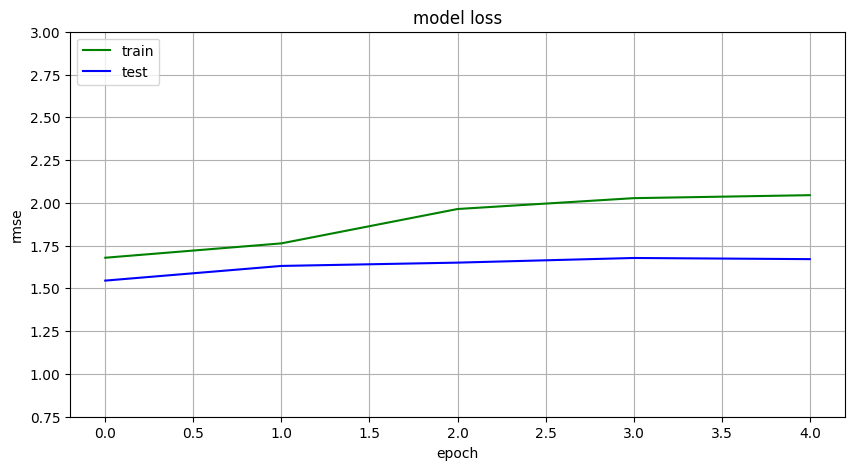

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['rmse'] , 'g')
plt.plot(history.history['val_rmse'] , 'b')
plt.title('model loss')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.ylim(0.75,3)
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
model.evaluate( [ X_valid[:,0], X_valid[:,1] ], y_valid)

5481/5481 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 2.1260 - rmse: 1.6604


[2.1207141876220703, 1.6594150066375732]

In [ ]:
# prompt: grabar el modelo entrenado a disco

model.save('modelo_entrenado.h5')


## Prediccion

In [ ]:
# Función para transformar IDs de manera segura
def safe_transform(encoder, values):
    # Transformar sólo si los valores están en el encoder
    try:
        return encoder.transform(values)
    except ValueError as e:
        print(f'Error al transformar valores: {e}')
        return np.zeros(len(values), dtype=np.int32)  # Valor predeterminado si el ID no se encuentra

# Ejemplo de IDs de usuario y producto
user_id = 'AGKHLEW2SOWHNMFQIJGBECAF7INQ'  # Reemplaza con el ID de usuario que desees predecir
product_id = 'B07NGFDN6G'  # Reemplaza con el ID de producto que desees predecir

# Verifica si el ID está en los datos de entrenamiento
if user_id in user_encoder.classes_ and product_id in product_encoder.classes_:
    user_encoded = user_encoder.transform([user_id])
    product_encoded = product_encoder.transform([product_id])

    # Realizar la predicción
    prediction = model.predict([user_encoded, product_encoded])

    # Mostrar la predicción
    print(f'La predicción para el usuario {user_id} y el producto {product_id} es: {prediction[0][0]}')
else:
    print(f'ID de usuario o producto desconocido: {user_id}, {product_id}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
La predicción para el usuario AGKHLEW2SOWHNMFQIJGBECAF7INQ y el producto B07NGFDN6G es: 4.271991729736328


In [ ]:
# Ejemplo de IDs de usuario y producto
user_id = 'AGKHLEW2SOWHNMFQIJGBECAF7INQ'  # Reemplaza con el ID de usuario que desees predecir
product_id = 'B07NGFDN6G'  # Reemplaza con el ID de producto que desees predecir

# Codificación de los IDs con los mismos encoders utilizados durante el entrenamiento
user_encoded = user_encoder.transform([user_id])
product_encoded = product_encoder.transform([product_id])

# Realizar la predicción
prediction = model.predict([user_encoded, product_encoded])

# Mostrar la predicción
print(f'La predicción para el usuario {user_id} y el producto {product_id} es: {prediction[0][0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
La predicción para el usuario AGKHLEW2SOWHNMFQIJGBECAF7INQ y el producto B07NGFDN6G es: 4.271991729736328


## Recomendacion
- Se elige un usuario, y se realiza sugerencia considerando:
  - La similitud de los productos comprados por este usuario con respecto al resto de los productos
  

In [ ]:
# Obtener los productos comprados por el usuario
userId='AGKHLEW2SOWHNMFQIJGBECAF7INQ'
comprado_por_el_usuario = df_ratings.parent_asin[ df_ratings.user_id==userId ].values
comprado_por_el_usuario

array(['B00YQ6X8EO', 'B081TJ8YS3'], dtype=object)

In [ ]:
print("El usuario compro:")
for i in comprado_por_el_usuario:
  print(get_title_by_asin(i))

El usuario compro:
Herbivore - Natural Sea Mist Texturizing Salt Spray (Coconut, 8 oz)
All Natural Vegan Dry Shampoo Powder - Eco Friendly, Root Touch Up | Hair Powder Volumizer | For Brown Hair, Brunette and Dark Hair. (Brun + Application Brush) Two Goats Apothecary


In [ ]:
# prompt: quiero eliminar o dropear de df_prod los codigos de producto que estan en comprado_por_el_usuario y guardarlo en un nuevo dataframe
productos_no_comprados = df_prod[~df_prod['parent_asin'].isin(comprado_por_el_usuario)]

In [ ]:
# Predicciones
X_u = np.full(len(productos_no_comprados), userId)
X_m = productos_no_comprados.index
X = np.stack((X_u, X_m), axis=1)

In [ ]:
X[:, 0] = user_encoder.transform(X[:, 0])


In [ ]:
X = X.astype(np.int32)
pred = model.predict( [ X[:,0], X[:,1]] , verbose=0)

In [ ]:
idx = np.argmax(pred)
resultado = df_prod.iloc[X_m[idx]]
resultado

,81172
parent_asin,B08P58T6X2
title,SIXQUEEN Makeup Sponge for Liquid Cream and We...
average_rating,5.0
rating_number,2


## Funcion

In [ ]:
def sugerencia(userId):
  # Obtener los productos comprados por el usuario
  comprado_por_el_usuario = df_ratings.parent_asin[ df_ratings.user_id==userId ].values

  print(f"El usuario {userId} compró:")
  for i in comprado_por_el_usuario:
      print(get_title_by_asin(i))

  productos_no_comprados = df_prod[~df_prod['parent_asin'].isin(comprado_por_el_usuario)]

  # Predicciones
  X_u = np.full(len(productos_no_comprados), userId)
  X_m = productos_no_comprados.index
  X = np.stack((X_u, X_m), axis=1)
  X[:, 0] = user_encoder.transform(X[:, 0])
  X = X.astype(np.int32)
  pred = model.predict( [ X[:,0], X[:,1]] , verbose=0)

  idx = np.argmax(pred)
  resultado = df_prod.iloc[X_m[idx]]

  print("\nSugerencia:")
  print(f"Producto: {resultado['title']}")
  print(f"Codigo: {resultado['parent_asin']}")
  print(f"Rating: {resultado['average_rating']}")
  print(f"Numero de Ratings: {resultado['rating_number']}")

  return




In [ ]:
userId= np.random.randint(len(df_ratings.user_id.unique())) #'AGKHLEW2SOWHNMFQIJGBECAF7INQ'
userId = df_ratings.user_id.unique()[userId]
sugerencia(userId)

El usuario AEA5VDIRZFZ3VR3MJLWFZ32XN3MA compró:
Pogopets 259 Silicone Tips Pet Grooming/Deshedding Glove - Perfect for Dogs, Cats & Horses with Long & Short Fur - Gentle Massage & Hair Removal Brush Mitt (Left)

Sugerencia:
Producto: W2B - Rosemary Officinalis - Rosemary Officinalis - Rosemary Officinalis Night Balm (Salon Size) 100ml/3.2oz
Codigo: B09CPBL5XC
Rating: 3.0
Numero de Ratings: 1
